In [1]:
import CMF
import PyPlot; plt = PyPlot;
import Random; Random.seed!(0);
import JLD

In [2]:
# Constants

N = 250
K, L = 3, 20
alpha, p_h, sigma, noise_scale = 0.1, 0.5, 0.2, 1.0

T_list = [500, 2500, 10_000, 50_000]
runtimes = Dict(
    500 => 30,
    2500 => 60,
    10_000 => 120,
    50_000 => 240
)

alg_list = [:hals, :mult, :anls]
labels = Dict(:hals => "HALS", :mult => "MULT", :anls => "ANLS")
;

## Generate synthetic datasets

We wish to better understand the performance of each algorithm for varying sizes of $T$. 
Since some audio and neuroscience datasets may span long timeframes, fast algorithms for large datasets are necessary to usefully apply the convolutive NMF model.

In these figures, we fix the number of rows (neurons) in $X$ to be `N=250`, and vary the number of columns (timebins) across 4 values: `T=500, T=2500, T=10000, T=50000`.

In [2]:
data_list = Dict()

for T in T_list
    data, trueW, trueH = CMF.synthetic_sequences(
        K=K, N=N, L=L, T=T,
        alpha=0.1, p_h=0.5, sigma=0.2, noise_scale=1.0
    )
    data_list[T] = (data, trueW, trueH)
end

## Fit data

In [3]:
results = Dict()
for T in T_list
    results[T] = Dict()
    
    for alg in alg_list
        results[T][alg] = CMF.fit_cnmf(
            data_list[T][1], alg=alg,
            K=K, L=L, max_time=runtimes[T], max_itr=Inf
        )
    end
end

In [4]:
JLD.save("./synthetic_comparison.jld", "results", results)

## Plot loss histories

In [3]:
results = JLD.load("./synthetic_comparison.jld", "results");

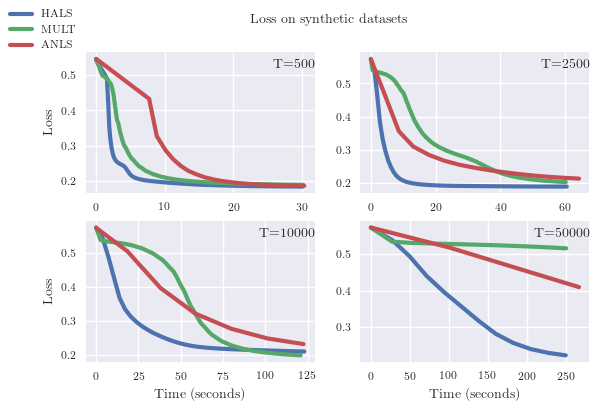

In [4]:
include("./plot_settings.jl")

# Plot

fig, axes = plt.subplots(2, 2, figsize=set_size(textwidth))
axes = [axes[1, 1], axes[1, 2], axes[2, 1], axes[2, 2]]
for i in 1:4
    T = T_list[i]
    
    for alg in alg_list
        r = results[T][alg]
        
        if (i == 1)
            label = labels[alg]
        else
            label = ""
        end
        
        axes[i].plot(
            r.time_hist, r.loss_hist,
            label=label
        )
    end
    axes[i].set_title(string("T=", T), loc="right", pad=-12)

    if (i == 3 || i == 4)
        axes[i].set_xlabel("Time (seconds)")
    end
    if (i == 1 || i == 3)
         axes[i].set_ylabel("Loss")
    end
    plt.show()
end

plt.suptitle("Loss on synthetic datasets")
fig.legend(loc="upper left")
plt.savefig("./synthetic_comparison.pdf", format="pdf")